In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

C:\Users\nonme\AppData\Local\Temp/ipykernel_17628/217595256.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [3]:
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series)
# df = read_csv("50moves.csv", sep=',', header=1)
# dataset = df.values
# trim_start = 200
# trim_end = 8400
# X = dataset[trim_start:trim_end,-16:]
# Y = dataset[trim_start:trim_end,5:8]

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales, dtype: float64


In [4]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [5]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [6]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [7]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [8]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 300, 4)

In [9]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)

In [10]:
lstm_model.predict(train_reshaped, batch_size=1, verbose=0, use_multiprocessing=False)

array([[-0.47331727],
       [-0.03369676],
       [-0.44955003],
       [ 0.03431135],
       [-0.46105808],
       [-0.09947388],
       [-0.4874631 ],
       [-0.11910428],
       [ 0.16909847],
       [ 0.6038684 ],
       [-0.99395555],
       [-0.03066075],
       [-0.2769534 ],
       [ 0.17958164],
       [-0.23848101],
       [-0.3033895 ],
       [ 0.42658013],
       [-0.391918  ],
       [ 0.37769544],
       [-0.23111296],
       [ 0.2960418 ],
       [-0.61768043],
       [ 0.36779815]], dtype=float32)

Month=1, Predicted=300.116266, Expected=339.700000
Month=2, Predicted=382.588098, Expected=440.400000
Month=3, Predicted=367.349149, Expected=315.900000
Month=4, Predicted=411.752308, Expected=439.300000
Month=5, Predicted=331.164372, Expected=401.300000
Month=6, Predicted=424.260139, Expected=437.400000
Month=7, Predicted=411.121444, Expected=575.500000
Month=8, Predicted=409.550908, Expected=407.600000
Month=9, Predicted=441.359498, Expected=682.000000
Month=10, Predicted=400.801437, Expected=475.300000
Month=11, Predicted=367.710836, Expected=581.300000
Month=12, Predicted=330.598980, Expected=646.900000
Test RMSE: 144.209


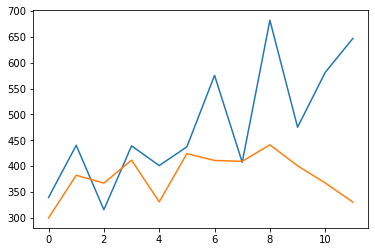

In [11]:

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()